# Data 102 Final Project: Election Finances

By Jessie Houng, Rithika Neti, Ritvik Iyer, and Sunny Shen

*Remark*: The Data Cleaning and EDA sections of the notebook are shown in reverse order compared to where they appear in the report because we performed EDA in multiple stages. 

## 1) Data Cleaning

In [ ]:
# Installing required libraries 
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn 
!pip install fuzzy-match
!pip install scipy

In [93]:
# Import Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from fuzzy_match import match
import scipy.stats as stats
import warnings
warnings.simplefilter('ignore')

# Settings
pd.set_option('max_columns', None)

### a) Clean Endorsements Data

In [46]:
# Read in Primary Candidates 2018 data
dem = pd.read_csv('data/dem_candidates.csv', error_bad_lines=False, encoding='latin-1')
rep = pd.read_csv('data/rep_candidates.csv', error_bad_lines=False, encoding='latin-1')

# Remove candidates not running in national elections 
rep = rep[rep['Office Type'] != 'Governor']
dem = dem[dem['Office Type'] != 'Governor']

# Set column for party affiliations 
dem['Party'] = 'D'
rep['Party'] = 'R'

# Fill values for partisan lean for Republican candidates
partisan_lean_by_district = dict(zip(dem['District'], dem['Partisan Lean']))
rep['Partisan Lean'] = rep['District'].map(partisan_lean_by_district)
prop_filled_v1 = len(rep['Partisan Lean'].dropna())/len(rep['Partisan Lean'])

# Impute partisan lean for Republican candidates based on Senate, then average of House districts within state
senate_leans = dem[dem['District'].str.contains('Senate')][['State', 'Partisan Lean']].drop_duplicates()
partisan_lean_by_state = dict(zip(senate_leans['State'], senate_leans['Partisan Lean']))
house_leans = dem[['Candidate','State','District','Partisan Lean']][
    dem['District'].str.contains('House')].groupby('State').mean().reset_index().dropna()
for state, lean in zip(house_leans['State'], house_leans['Partisan Lean']):
    if state not in partisan_lean_by_state.keys():
        partisan_lean_by_state[state] = lean
for index, row in rep.iterrows():
    state = rep.loc[index, 'State']
    if (pd.isna(rep.loc[index, 'Partisan Lean'])) and (state in partisan_lean_by_state):
        rep.loc[index, 'Partisan Lean'] = partisan_lean_by_state[state]
prop_filled_v2 = len(rep['Partisan Lean'].dropna())/len(rep['Partisan Lean'])

# Identify the states with Republican candidates who still have missing partisan leans 
missing_state_rep = rep[rep['Partisan Lean'].isna()]['State'].value_counts().index.values

# Select the Republican candidates who have missing partisan leans 
invalid_rep_cand = rep[rep['State'].isin(missing_state_rep)]

# Select the Republican candidates who do not have missing partisan leans 
valid_rep_cand = rep[~(rep['State'].isin(missing_state_rep))]

# Deal with missing values in endorsement data
final_dem = dem
final_rep = valid_rep_cand
dem_endorse_support_cols = [x for x in final_dem.columns if 'Support' in x or 'Endorsed' in x]
rep_endorse_support_cols = [x for x in final_rep.columns if 'Support' in x or 'Endorsed' in x]
endorse_map = {'Yes': 1, 'No': -1, np.nan: 0}
final_dem.loc[:, dem_endorse_support_cols] = final_dem.loc[:, dem_endorse_support_cols].replace(endorse_map)
final_rep.loc[:, rep_endorse_support_cols] = final_rep.loc[:, rep_endorse_support_cols].replace(endorse_map)
party_support = np.hstack([final_dem['Party Support?'].values, final_rep['Rep Party Support?'].values])
full_candidates = pd.concat([final_dem, final_rep]).drop(columns=['Party Support?', 'Rep Party Support?'])
full_candidates['Party Support?'] = party_support
cand_endorse_support_cols = [x for x in full_candidates.columns if 'Support' in x or 'Endorsed' in x]
full_candidates.loc[:, cand_endorse_support_cols] = full_candidates.loc[:, cand_endorse_support_cols].fillna(-1)
full_candidates = full_candidates.drop(columns=['General Status', 'Race', 'Veteran?',
                                                'LGBTQ?', 'Elected Official?', 'Self-Funder?',
                                               'STEM?', 'Obama Alum?', 'Guns Sense Candidate?',
                                               'Won Primary'])

# Set district numbers 
full_candidates['District_Num'] = [
    int(x[-1]) if len(x[-1])<=2 else 0 for x in full_candidates['District'].str.split()]

### b) Clean FEC Campaigner Dataset

In [3]:
# Read in FEC All Candidates data
fin16 = pd.read_csv('data/weball16.txt', sep="|", header=None)
fin18 = pd.read_csv('data/weball18.txt',  sep="|", header=None)

# Set column names  
fin_col = ['CAND_ID', 'CAND_NAME', 'CAND_ICI', 'PTY_CD', 'CAND_PTY_AFFILIATION',
           'TTL_RECEIPTS', 'TRANS_FROM_AUTH', 'TTL_DISB', 'TRANS_TO_AUTH', 'COH_BOP', 
           'COH_COP', 'CAND_CONTRIB', 'CAND_LOANS', 'OTHER_LOANS', 'CAND_LOAN_REPAY', 
           'OTHER_LOAN_REPAY', 'DEBTS_OWED_BY', 'TTL_INDIV_CONTRIB', 'CAND_OFFICE_ST', 
           'CAND_OFFICE_DISTRICT', 'SPEC_ELECTION', 'PRIM_ELECTION', 'RUN_ELECTION', 
           'GEN_ELECTION', 'GEN_ELECTION_PRECENT', 'OTHER_POL_CMTE_CONTRIB',
           'POL_PTY_CONTRIB', 'CVG_END_DT', 'INDIV_REFUNDS', 'CMTE_REFUNDS']
fin16.columns = fin_col
fin18.columns = fin_col

# Set year
fin18['YEAR'] = 18
fin16['YEAR'] = 16

# Combine datasets 
fin = pd.concat([fin16, fin18])

# Reformat party names 
fin['CAND_PTY_AFFILIATION'] = fin['CAND_PTY_AFFILIATION'].map({'REP':'R',
                                                               'DEM':'D'})

# Reformat candidate names  
fin['CAND_NAME'] = [" ".join(n.lower().title().split(", ")[::-1]) for n in fin['CAND_NAME']]

# Remove missing district numbers and re-code data 
fin = fin[~fin['CAND_OFFICE_DISTRICT'].isna()]
fin['CAND_OFFICE_DISTRICT']= fin['CAND_OFFICE_DISTRICT'].astype(int)

### c) Merge Endorsements Data with FEC Campaigner Data

In [4]:
# Fuzzy match names 
fuzzy_name = [match.extract(x, fin['CAND_NAME'], limit=1, score_cutoff=0.55) for x in full_candidates['Candidate'].values]
fuzzy_name_match = [x[0][0] if x!=[] else '' for x in fuzzy_name]
fuzzy_name_match_score = [x[0][1] if x!=[] else '' for x in fuzzy_name]
full_candidates['fuzzy_name_match'] = fuzzy_name_match
full_candidates['fuzzy_name_match_score'] = fuzzy_name_match_score

# Merge datasets based on fuzzy matched names, state, and party and drop duplicates running in special elections
cand_fin = pd.merge(fin[['CAND_ID', 'CAND_NAME', 'CAND_OFFICE_DISTRICT', 
                         'CAND_OFFICE_ST', 'CAND_ICI', 'PTY_CD', 
                         'CAND_PTY_AFFILIATION', 'TTL_RECEIPTS', 
                        'TRANS_FROM_AUTH','CAND_CONTRIB',
                        'TTL_INDIV_CONTRIB','OTHER_POL_CMTE_CONTRIB']], 
                    full_candidates, 
                    left_on=['CAND_NAME','CAND_OFFICE_ST', 'CAND_PTY_AFFILIATION'] , 
                    right_on=['fuzzy_name_match', 'State', 'Party'])
cand_fin = cand_fin[['Candidate', 'CAND_ID', 'District', 'Party', 'State', 'Emily Endorsed?',
                     'Partisan Lean', 'TTL_RECEIPTS', 'TRANS_FROM_AUTH', 'CAND_CONTRIB',
                     'TTL_INDIV_CONTRIB', 'OTHER_POL_CMTE_CONTRIB', 'Primary %',
                     'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?',
                     'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 
                     'PCCC Endorsed?', 'Indivisible Endorsed?', 'WFP Endorsed?',
                     'VoteVets Endorsed?', 'No Labels Support?', 'Party Support?', 
                     'Trump Endorsed?', 'Bannon Endorsed?', 'Great America Endorsed?',
                     'NRA Endorsed?', 'Right to Life Endorsed?', 'Susan B. Anthony Endorsed?',
                     'Club for Growth Endorsed?', 'Koch Support?', 'House Freedom Support?',
                     'Tea Party Endorsed?', 'Main Street Endorsed?', 'Chamber Endorsed?', 'Race Type', 'CAND_ICI']]

# Find duplicate candidates who are listed as running in multiple roles (i.e incumbent, open race, challenger)
dupes = cand_fin.groupby('Candidate').count()[['CAND_ICI']].reset_index()
dupe_names = dupes[dupes['CAND_ICI'] > 1]['Candidate'].values
keep_dupe_idx = []
for name in dupe_names:
    filtered_dupe_cand = cand_fin[cand_fin['Candidate'] == name]
    argmax_ind_cont = filtered_dupe_cand.TTL_INDIV_CONTRIB.argmax()
    row_idx = filtered_dupe_cand.index[argmax_ind_cont]
    keep_dupe_idx.append(row_idx)
to_remove = cand_fin[cand_fin['Candidate'].isin(dupe_names)].drop(keep_dupe_idx).index.values
cand_fin = cand_fin.drop(to_remove)

### d) Clean FEC Individual Contributions Data

In [6]:
# Read in Individual Donor data (warning: these are very large files, ~4 GB each)
indiv16 = pd.read_csv('data/indiv16/itcont.txt', sep="|", header=None, low_memory=False)
indiv18 = pd.read_csv('data/indiv18/itcont.txt', sep="|", header=None, low_memory=False)
indiv_cols = pd.read_csv('data/indiv_header_file.csv').columns

# Filter down to campaign years we are interested in 
P2018_indiv16 = indiv16[indiv16[3]=='P2018']
P2018_indiv18 = indiv18[indiv18[3]=='P2018']

# Set column names 
P2018_indiv16.columns = indiv_cols
P2018_indiv18.columns = indiv_cols

# Concatenate data for 2018 primary cycle together
P2018 = pd.concat([P2018_indiv16, P2018_indiv18])

### e) Clean FEC Campaign-Committee Linkages Data

In [7]:
# Read in linkage data
ccl16 = pd.read_csv('data/ccl16.txt', sep='|', header=None)
ccl18 = pd.read_csv('data/ccl18.txt', sep='|', header=None)

# Set column names 
ccl_cols = ['CAND_ID', 'CAND_ELECTION_YR', 'FEC_ELECTION_YR', 'CMTE_ID', 'CMTE_TP', 'CMTE_DSGN', 'LINKAGE_ID']
ccl16.columns = ccl_cols
ccl18.columns = ccl_cols

# Filter down to campaign years we are interested in 
ccl16 = ccl16[ccl16['CAND_ELECTION_YR']==2018]
ccl18 = ccl18[ccl18['CAND_ELECTION_YR']==2018]

# Concatenate linkages for 2018 primary cycle together 
ccl = pd.concat([ccl16, ccl18]).drop_duplicates(subset=['CAND_ID', 'CMTE_ID'])

### f) Merge Individual Contributions with Campaign-Committee Linkages

In [11]:
# Extract Number of Unique individual contributions from 2018 contribution data 
cmt_count = P2018[['CMTE_ID', 'TRANSACTION_AMT', 'NAME']].groupby(
    ['CMTE_ID', 'NAME']).count().reset_index().groupby('CMTE_ID').count().reset_index()
cmt_count = cmt_count.drop(columns=['NAME']).rename(columns={'TRANSACTION_AMT': 'Num_Unique_Contributions'})

# Merge contributions by committee id to linkage data
cand_count = pd.merge(cmt_count, ccl, on = 'CMTE_ID').drop(columns=['CMTE_TP', 'CMTE_DSGN', 'LINKAGE_ID', 
                                                      'CAND_ELECTION_YR', 'FEC_ELECTION_YR']).groupby(
                                                    'CAND_ID').sum().reset_index()

### g) Merge Candidate Endorsements with Number of Unique Donors

In [19]:
# Do an inner join based on candidate id 
final_candidates = pd.merge(cand_fin, cand_count, on='CAND_ID', how='inner')

## 2) Exploratory Data Analysis

## 3) Method #1: Multiple Hypothesis Testing

In [143]:
def make_df_from_sample(sample, label):
    """Constructs a dataframe for a permutation test based on sample values and given label"""
    df = pd.DataFrame()
    df['Value'] = sample 
    df['Label'] = label
    return df
    
def compute_KS_stat(sample_A, sample_B):
    """Computes the KS statistic between two samples A and B"""
    return stats.ks_2samp(samp1, sample_B)[0]

def permute_df_by_label(df):
    """Permutes labels in a given dataframe for the purposes of permutation testing"""
    shuffled_df = df.copy()
    shuffled_df['Label'] = np.random.permutation(df['Label'].values)
    return shuffled_df
    
def ks_2_sample_permutation_test(sample_A, sample_B, num_permutations=5000):
    """Performs a two-sample permutation test based on KS-statistic for two sample A and B.
    Returns an array of test statistics and the corresponding p-value of the test. 
    H_0: The Cumulative Distribution function of A is equal to Cumulative Distribution function of B
    H_1: The CDF of A is not equal to the CDF of B (two-sided)
    """
    obs_stat = compute_KS_stat(sample_A, sample_B)
    obs_df_A = make_df_from_sample(sample_A, label='A')
    obs_df_B = make_df_from_sample(sample_B, label='B')
    combined_df = pd.concat([obs_df_A, obs_df_B])
    test_statistics = np.array([])
    for _ in np.arange(num_permutations):
        permuted_df = permute_df_by_label(combined_df)
        df_A = permuted_df[permuted_df['Label'] == 'A']
        df_B = permuted_df[permuted_df['Label'] == 'B']
        ks_stat = compute_KS_stat(df_A['Value'].values, df_B['Value'].values)
        test_statistics = np.append(test_statistics, ks_stat)
    p_value = np.count_nonzero(np.abs(test_statistics) > obs_stat)/num_permutations
    return test_statistics, obs_stat, p_value
        

def ks_test(sample_A, sample_B):
    """Performs a two-sample KS-test between sample A and B and returns p-value
    H_0: The CDF of A is equal to the CDF of B
    H_1: The CDFs of A and B are not equal (two-sided)
    """
    return stats.ks_2samp(samp1, sample_B)[1]

In [161]:
# Extract two samples 

tbl1 = valid_rep_cand.groupby('District').count()['Candidate'].reset_index().groupby('Candidate').count().reset_index()
samp1 = np.repeat(tbl1['Candidate'].values, tbl1['District'].values)
tbl2 = invalid_rep_cand.groupby('District').count()['Candidate'].reset_index().groupby('Candidate').count().reset_index()
samp2 = np.repeat(tbl2['Candidate'].values, tbl2['District'].values)

In [145]:
ks_test(samp1, samp2)

0.22085261842677528

This p-value is too big! This is because the KS-test assumes A and B come from continuous distributions, so it is is less powerful in cases where A and B are discrete. Instead, we take a permutation approach as follows: 

In [146]:
data, obs, p = ks_2_sample_permutation_test(samp1, samp2)

The p-value was 0.018


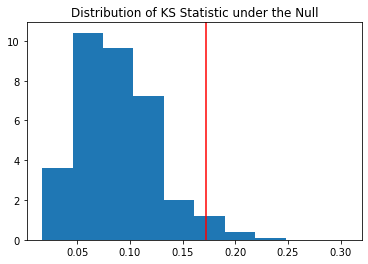

In [159]:
plt.title('Distribution of KS Statistic under the Null')
plt.hist(data, density=True)
plt.axvline(x=obs, color='r');
print(f'The p-value was {p}')

## 4) Method #2: Bayesian Inference 

### a) Feature Extraction 

In [52]:
all_candidates = pd.read_csv('data/all_candidates.csv').drop_duplicates(subset=['Candidate'])

,Candidate,CAND_ID,District,Party,State,Emily Endorsed?,Partisan Lean,TTL_RECEIPTS,TRANS_FROM_AUTH,CAND_CONTRIB,TTL_INDIV_CONTRIB,OTHER_POL_CMTE_CONTRIB,Primary %,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,Party Support?,Trump Endorsed?,Bannon Endorsed?,Great America Endorsed?,NRA Endorsed?,Right to Life Endorsed?,Susan B. Anthony Endorsed?,Club for Growth Endorsed?,Koch Support?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,Race Type,CAND_ICI,Num_Unique_Contributions
0,Wendy Rogers,H2AZ09035,U.S. House Arizona District 1,R,AZ,-1.0,-24.559999,1423836.68,0.00,698.53,1302250.00,83750.00,43.400000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,Regular,C,382
1,Michael Eggman,H4CA10075,U.S. House California District 10,D,CA,-1.0,0.620000,1639589.92,16038.75,0.00,1195080.49,375444.76,21.340000,0.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Regular,C,246
2,Wendy Reed,H6CA23206,U.S. House California District 23,D,CA,0.0,-25.379999,40357.40,0.00,1887.97,22601.93,7500.00,34.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Regular,C,14
3,Justin Fareed,H4CA24142,U.S. House California District 24,R,CA,-1.0,-7.729107,2353070.71,0.00,739.26,2096376.98,231850.00,78.370000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Regular,O,342
4,Bryan Caforio,H6CA25177,U.S. House California District 25,D,CA,-1.0,2.020000,1706520.29,22679.24,1974.17,1173006.17,456702.21,38.259998,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Regular,C,1078


In [59]:
def get_num_competitors(cand_name, cand_df=final_candidates, ref_df=all_candidates):
    """For a specified candidate name in the candidate dataframe, gets the number of 
    opposing candidates in the same district with respect to the reference dataframe."""
    district_name = cand_df[cand_df['Candidate'] == cand_name]#.loc[0, 'District']
    party = cand_df[cand_df['Candidate'] == cand_name]#.loc[0, 'Party']
    print(district_name, party)
    num_competitors = ref_df[(
        ref_df['District'] == district_name) & (ref_df['Party'] == party)].shape[0] - 1
    return num_competitors 

final_candidates['Candidate'].apply(get_num_competitors)

0    U.S. House Arizona District 1
Name: District, dtype: object 0    R
Name: Party, dtype: object


ValueError: Can only compare identically-labeled Series objects

In [44]:
# Initialize candidate feature dataframe
cand_features = pd.DataFrame()

# Read in final candidate data
final_candidates = pd.read_csv('data/final_candidates.csv')

# Set candidate names, districts, parties, and political leans based on final candidate data
cand_features['Candidate'] = final_candidates['Candidate']
cand_features['District'] =  final_candidates['District']
cand_features['Party'] =  final_candidates['Party']
cand_features['Partisan Lean'] =  final_candidates['Partisan Lean']

# Find the number of positive endorsements for each candidate
dem_endorse_support_cols = [x for x in final_candidates.columns if 'Support' in x or 'Endorsed' in x]
rep_endorse_support_cols = [x for x in final_candidates.columns if 'Support' in x or 'Endorsed' in x]
endorse_cols = dem_endorse_support_cols + rep_endorse_support_cols
pos_endorsements = final_candidates.loc[:, endorse_cols].applymap(
    lambda x: 0 if x == -1 else x).apply(np.sum, axis=1).apply(int)
cand_features['Positive Endorsement Count'] =  pos_endorsements

# Find the number of competitors each candidate is opposing in their primary


0       2
1       0
2       0
3       4
4       2
       ..
744     0
745     0
746     0
747     0
748    10
Length: 749, dtype: int64

In [ ]:




cand_features['Number of Competitors'] = ...
cand_features['Number of Unique Donors'] = final_candidates['Num_Unique_Contributions']